In [50]:
import numpy as np 
import pandas as pd 
Data = pd.read_csv("cleaned_star_data.csv").dropna()
import optax
import matplotlib.pyplot as plt
from typing import List
import equinox as eqx
import jax
import jax.numpy as jnp
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax

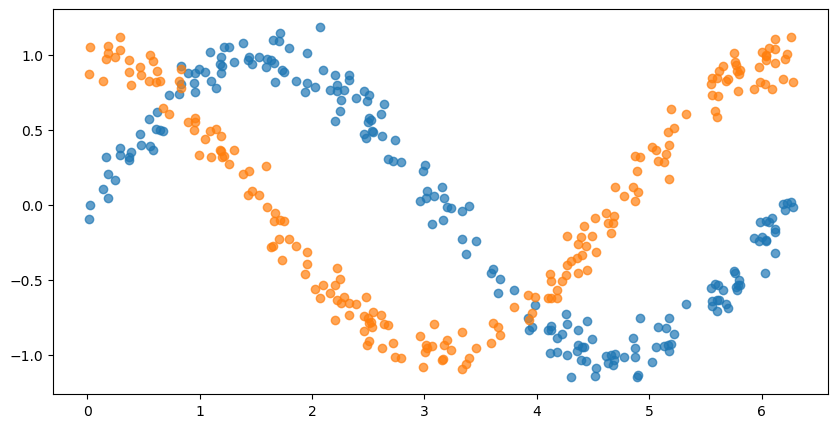

In [51]:

N_SAMPLES = 200
key, xkey, ynoisekey, znoisekey = jax.random.split(jax.random.PRNGKey(0), 4)

# Generate sorted t_s values
t_s = jax.random.uniform(xkey, (N_SAMPLES, 1), minval=0.0, maxval=2 * jnp.pi)
t_s = jnp.sort(t_s, axis=0)

# Generate y_s and z_s with noise
y_noise = jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.1
z_noise = jax.random.normal(znoisekey, (N_SAMPLES, 1)) * 0.1

y_s = jnp.sin(t_s) + y_noise
z_s = jnp.cos(t_s) + z_noise

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(t_s, y_s, label="sin wave with noise", alpha=0.7)
plt.scatter(t_s, z_s, label="cos wave with noise", alpha=0.7)

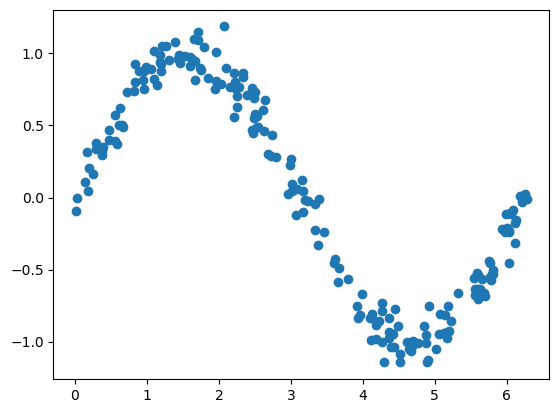

In [52]:
y_s = y_s.reshape(N_SAMPLES)
z_s = z_s.reshape(N_SAMPLES)
t_s = t_s.reshape(len(t_s))
plt.scatter(t_s, y_s)

In [53]:
"""N_SAMPLES = 200
key, xkey, ynoisekey = jax.random.split(jax.random.PRNGKey(0), 3)
t_s = jax.random.uniform(xkey, (N_SAMPLES, 1), minval=0.0, maxval=2*jnp.pi).sort(axis = 0)
y_s = jnp.sin(t_s) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.1
z_s = jnp.cos(t_s) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.1
plt.scatter(t_s, y_s)
plt.scatter(t_s, z_s)"""


'N_SAMPLES = 200\nkey, xkey, ynoisekey = jax.random.split(jax.random.PRNGKey(0), 3)\nt_s = jax.random.uniform(xkey, (N_SAMPLES, 1), minval=0.0, maxval=2*jnp.pi).sort(axis = 0)\ny_s = jnp.sin(t_s) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.1\nz_s = jnp.cos(t_s) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.1\nplt.scatter(t_s, y_s)\nplt.scatter(t_s, z_s)'

In [54]:
#y_s = y_s.sort(axis = 0)
#z_s = z_s.sort(axis = 0)

In [55]:
class LinearFunction(eqx.Module):
    layers: list

    def __init__(self, key): 
        key1, key2, key3, key4, key5= jax.random.split(key, 5)
        self.layers = [eqx.nn.Linear(2,20, key = key1), 
                       eqx.nn.Linear(20, 40, key = key2),
                       eqx.nn.Linear(40, 2, key = key3),
                    ] 
    def __call__(self, t, y, *args):
        print("DEBUG", t,y)
        for layer in self.layers[:-1]:
            y = jax.nn.relu(layer(y))
        y = self.layers[-1](y)
        print("DEBUG2", y)
        return y


In [56]:
key = jax.random.PRNGKey(42)
x,y = jax.random.split(jax.random.PRNGKey(42), 2)
print(jax.random.split(key, 2)[0])
print(type(x))

[2465931498 3679230171]
<class 'jaxlib.xla_extension.ArrayImpl'>


In [57]:
initial = jnp.array([z_s[0], y_s[0]])

In [58]:
key = jax.random.PRNGKey(41)
key, subkey = jax.random.split(key, 2)
model2 =  LinearFunction(subkey)
initial = initial.reshape(2,)
initial



Array([ 0.86965615, -0.09554964], dtype=float32)

In [59]:
x = model2(t_s[0], initial)
x


DEBUG 0.013923422 [ 0.86965615 -0.09554964]
DEBUG2 [ 0.31307247 -0.07391838]


Array([ 0.31307247, -0.07391838], dtype=float32)

In [60]:
def model_to_loss(model, y_s, z_s, t_s):
    # Solve the differential equation
    if not jnp.all(t_s[1:] > t_s[:-1]):
        raise ValueError("t_s is not strictly increasing after sorting.")

    #print("Sorted t_s:", t_s)
    #print(y_s[0], z_s[0])
    solutions = diffrax.diffeqsolve(
        diffrax.ODETerm(model),
        diffrax.Tsit5(),
        t0=float(t_s[0]),
        t1=float(t_s[-1]),
        dt0=0.01,
        y0=jnp.array([0,1], dtype=jnp.float64),  
        stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
        saveat=diffrax.SaveAt(ts=jnp.sort(t_s)),
    )
    

    # Extract solutions for y and z
    y = solutions.ys[:N_SAMPLES-1, 0]
    z = solutions.ys[:N_SAMPLES-1, 1]

    
    # Use nan_to_num to handle NaNs
    y = jnp.nan_to_num(y, nan=0.0)
    z = jnp.nan_to_num(z, nan=0.0)
   
    # Calculate squared differences for the loss
    y_diff = ((y - y_s[:N_SAMPLES-1]) ** 2)
    z_diff = (z - z_s[:N_SAMPLES-1]) ** 2
   # print(jnp.mean(y_diff) + jnp.mean(z_diff))
    return jnp.sqrt(jnp.mean(y_diff)) + jnp.sqrt(jnp.mean(z_diff))

In [61]:
model_to_loss_and_grad = eqx.filter_value_and_grad(model_to_loss)


In [62]:
opt = optax.sgd(0.05)  # Here you could also use optax.adam(...)
#opt_state = opt.init(eqx.filter(model2, eqx.is_array))


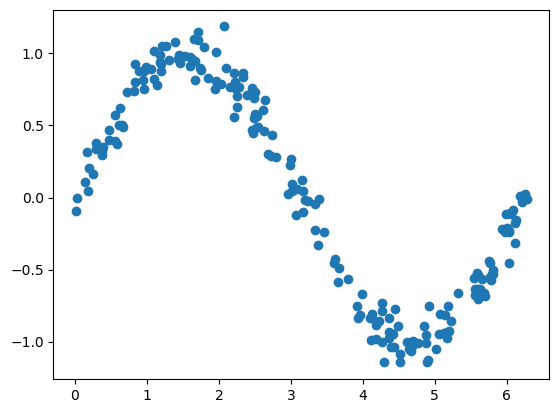

In [63]:
plt.scatter(t_s, y_s)

In [64]:
def make_step(m, opt_s, y_s, z_s, t_s):
    loss, grad = model_to_loss_and_grad(eqx.filter(m, eqx.is_inexact_array), y_s, z_s, t_s)
    updates, opt_s = opt.update(grad, opt_s, m)
    m = eqx.apply_updates(m, updates)
    return m, opt_s, loss

loss_history = []
MODEL = LinearFunction(subkey)
opt_state = opt.init(eqx.filter(MODEL, eqx.is_array))
for epoch in range(500):
    MODEL, opt_state, loss = make_step(MODEL, opt_state, y_s, z_s, t_s)
    loss_history.append(loss)

    
    print(f"Epoch {epoch}, loss {loss}")

DEBUG 0.0 Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=4/0)>
DEBUG2 Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=4/0)>
DEBUG Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=5/0)> Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=5/0)>
DEBUG2 Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=5/0)>
DEBUG Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=5/0)> Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=5/0)>
DEBUG2 Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=5/0)>


/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_7334/3523718135.py:14: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array([0,1], dtype=jnp.float64),


Epoch 0, loss 2.6909706592559814
Epoch 1, loss 1.707527756690979
Epoch 2, loss 1.774287462234497
Epoch 3, loss 1.540999174118042
Epoch 4, loss 1.5264835357666016
Epoch 5, loss 1.5084086656570435
Epoch 6, loss 1.4884936809539795
Epoch 7, loss 1.4747776985168457
Epoch 8, loss 1.473301887512207
Epoch 9, loss 1.4455240964889526
Epoch 10, loss 1.4439973831176758
Epoch 11, loss 1.4388809204101562
Epoch 12, loss 1.4758262634277344
Epoch 13, loss 1.4425312280654907
Epoch 14, loss 1.4804162979125977
Epoch 15, loss 1.4204661846160889
Epoch 16, loss 1.3941253423690796
Epoch 17, loss 1.3230717182159424
Epoch 18, loss 1.2972463369369507
Epoch 19, loss 1.2740023136138916
Epoch 20, loss 1.2539842128753662
Epoch 21, loss 1.2311720848083496
Epoch 22, loss 1.2093278169631958
Epoch 23, loss 1.1928632259368896
Epoch 24, loss 1.1788095235824585
Epoch 25, loss 1.1747725009918213
Epoch 26, loss 1.2078218460083008
Epoch 27, loss 1.2101833820343018
Epoch 28, loss 1.2844617366790771
Epoch 29, loss 1.16109228134

/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_7334/3523718135.py:14: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array([0,1], dtype=jnp.float64),


Epoch 34, loss 0.999159574508667
Epoch 35, loss 1.006940245628357
Epoch 36, loss 1.1342999935150146
Epoch 37, loss 0.9991999864578247
Epoch 38, loss 1.037229061126709
Epoch 39, loss 0.8824811577796936
Epoch 40, loss 0.873725414276123
Epoch 41, loss 0.8701381087303162
Epoch 42, loss 1.2830655574798584
Epoch 43, loss 0.8873090744018555
Epoch 44, loss 0.7211060523986816
Epoch 45, loss 0.6992983222007751
Epoch 46, loss 1.0555943250656128
Epoch 47, loss 0.7898746728897095
Epoch 48, loss 0.6328755617141724
Epoch 49, loss 1.1221427917480469
Epoch 50, loss 0.6848822832107544
Epoch 51, loss 0.8090302348136902
Epoch 52, loss 1.3891757726669312
Epoch 53, loss 1.1895413398742676
Epoch 54, loss 1.081141471862793
Epoch 55, loss 0.9571211338043213
Epoch 56, loss 0.8177165985107422
Epoch 57, loss 0.5841467380523682
Epoch 58, loss 0.7249733209609985
Epoch 59, loss 1.0243743658065796
Epoch 60, loss 0.7905651330947876
Epoch 61, loss 0.536034107208252
Epoch 62, loss 0.7147741317749023
Epoch 63, loss 1.111

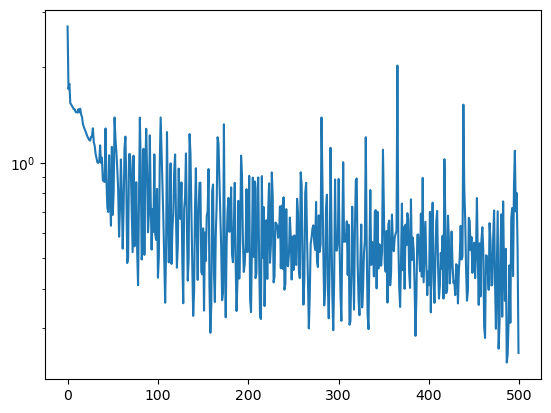

In [65]:
plt.plot(loss_history)
plt.yscale('log')

In [66]:
solutions = diffrax.diffeqsolve(
        diffrax.ODETerm(MODEL),
        diffrax.Tsit5(),
        t0=float(t_s[0]),
        t1=float(t_s[-1]),
        dt0=0.01,
        y0=jnp.array([0.0, 1.0], dtype=jnp.float64),  
        stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
        saveat=diffrax.SaveAt(ts=jnp.sort(t_s)),
    )
solutions.ys[:, 0]

/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_7334/2539220087.py:7: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array([0.0, 1.0], dtype=jnp.float64),


Array([ 0.        ,  0.00821325,  0.13147727,  0.15648465,  0.17045538,
        0.1747539 ,  0.22982724,  0.2717371 ,  0.27789518,  0.35091406,
        0.3526869 ,  0.36423862,  0.4395541 ,  0.44482502,  0.5054195 ,
        0.51394534,  0.53608733,  0.5578152 ,  0.5653755 ,  0.59024405,
        0.60631293,  0.6481642 ,  0.7140893 ,  0.7306872 ,  0.7319855 ,
        0.77009594,  0.80704767,  0.8142123 ,  0.8165308 ,  0.8340076 ,
        0.86959165,  0.8951516 ,  0.8975614 ,  0.9197477 ,  0.9383647 ,
        0.9404027 ,  0.941296  ,  0.94507736,  0.95213544,  0.9688642 ,
        0.9830935 ,  1.0005178 ,  1.0066077 ,  1.0078504 ,  1.0093781 ,
        1.010263  ,  1.0063332 ,  1.0052752 ,  1.0015665 ,  0.9978827 ,
        0.99657893,  0.9952184 ,  0.98771465,  0.98647296,  0.98205423,
        0.9788127 ,  0.9652352 ,  0.94809955,  0.91704243,  0.9114434 ,
        0.9111025 ,  0.8812422 ,  0.8643082 ,  0.8520191 ,  0.8206922 ,
        0.7973625 ,  0.79642165,  0.78831255,  0.78745866,  0.77

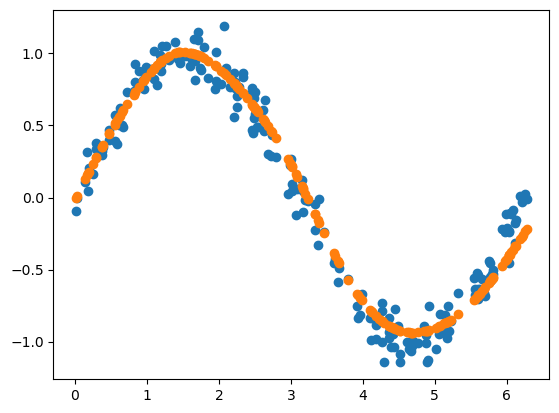

In [67]:
plt.scatter(t_s, y_s)
plt.scatter(t_s,solutions.ys[:, 0])

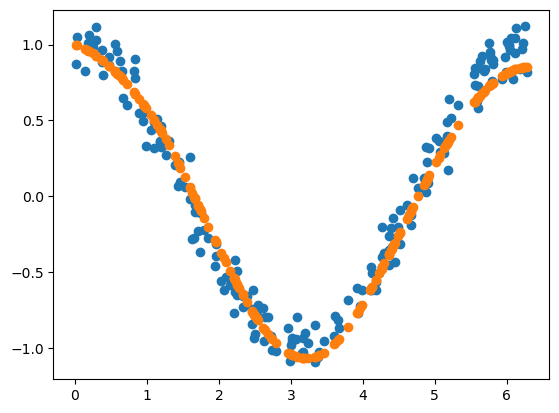

In [68]:
plt.scatter(t_s, z_s)
plt.scatter(t_s,solutions.ys[:, 1])